In [3]:
### Statistical inference

We are going to perform a re-binning for the statistical inference.
This is planned to be conveniently provided via cabinetry (see [cabinetry#412](https://github.com/scikit-hep/cabinetry/issues/412), but in the meantime we can achieve this via [template building overrides](https://cabinetry.readthedocs.io/en/latest/advanced.html#overrides-for-template-building).
The implementation is provided in a function in `utils/`.

A statistical model has been defined in `config.yml`, ready to be used with our output.
We will use `cabinetry` to combine all histograms into a `pyhf` workspace and fit the resulting statistical model to the pseudodata we built.


SyntaxError: invalid syntax (663949152.py, line 3)

In [4]:
#print(sys.path)

In [5]:
import logging
import time

import sys
sys.path.append('/home/cms-jovyan/analysis-grand-challenge/analyses/cms-open-data-ttbar')
import awkward as ak
import cabinetry
import cloudpickle
import correctionlib
from coffea import processor
from coffea.nanoevents import NanoAODSchema
from coffea.analysis_tools import PackedSelection
import copy
import hist
import matplotlib.pyplot as plt
import numpy as np
import pyhf

import utils # contains code for bookkeeping and cosmetics, as well as some boilerplate

logging.getLogger("cabinetry").setLevel(logging.INFO)

In [6]:
import utils.rebinning  # noqa: E402

cabinetry_config = cabinetry.configuration.load("cabinetry_config.yml")

# rebinning: lower edge 110 GeV, merge bins 2->1
rebinning_router = utils.rebinning.get_cabinetry_rebinning_router(cabinetry_config, rebinning=slice(110j, None, hist.rebin(2)))
cabinetry.templates.build(cabinetry_config, router=rebinning_router)
cabinetry.templates.postprocess(cabinetry_config)  # optional post-processing (e.g. smoothing)
ws = cabinetry.workspace.build(cabinetry_config)
cabinetry.workspace.save(ws, "workspace.json")

4j1b-CR_W+jets_Jet-energy-scale_Up has empty bins: [0]
4j2b-SR_W+jets has empty bins: [ 7 10]
4j2b-SR_W+jets_Jet-energy-scale_Up has empty bins: [7]
4j2b-SR_W+jets_b-tag-NP-1_Up has empty bins: [ 7 10]
4j2b-SR_W+jets_b-tag-NP-1_Down has empty bins: [ 7 10]
4j2b-SR_W+jets_b-tag-NP-2_Up has empty bins: [ 7 10]
4j2b-SR_W+jets_b-tag-NP-2_Down has empty bins: [ 7 10]
4j2b-SR_W+jets_b-tag-NP-3_Up has empty bins: [ 7 10]
4j2b-SR_W+jets_b-tag-NP-3_Down has empty bins: [ 7 10]
4j2b-SR_W+jets_b-tag-NP-4_Up has empty bins: [ 7 10]
4j2b-SR_W+jets_b-tag-NP-4_Down has empty bins: [ 7 10]
4j2b-SR_W+jets_W+jets-scale-variations_Up has empty bins: [ 7 10]
4j2b-SR_W+jets_W+jets-scale-variations_Down has empty bins: [ 7 10]
4j1b-CR_W+jets_Jet-energy-scale_Up has empty bins: [0]
4j2b-SR_W+jets has empty bins: [ 7 10]
4j2b-SR_W+jets_Jet-energy-scale_Up has empty bins: [7]
4j2b-SR_W+jets_b-tag-NP-1_Up has empty bins: [ 7 10]
4j2b-SR_W+jets_b-tag-NP-1_Down has empty bins: [ 7 10]
4j2b-SR_W+jets_b-tag-NP-2_Up

In [7]:
!pyhf inspect workspace.json | head -n 20

                  Summary       
            ------------------  
               channels  2
                samples  5
             parameters  14
              modifiers  14

               channels  nbins
             ----------  -----
                4j1b CR   11  
                4j2b SR   11  

                samples
             ----------
                 W+jets
  single top, s-channel
  single top, t-channel
                     tW
                  ttbar



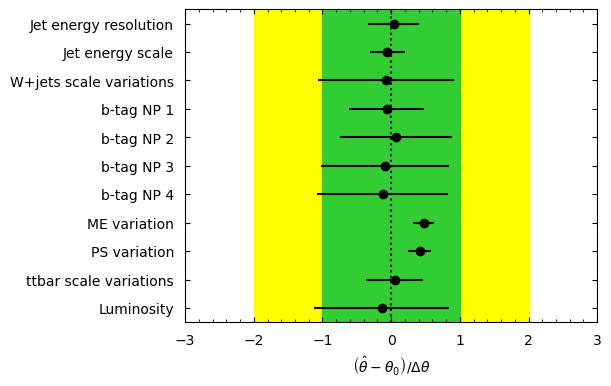

In [8]:
model, data = cabinetry.model_utils.model_and_data(ws)
fit_results = cabinetry.fit.fit(model, data)

cabinetry.visualize.pulls(
    fit_results, exclude= "ttbar_norm", close_figure=True, save_figure=True 
)

In [18]:
#### model_pred = cabinetry.model_utils.prediction(model)
#figures = cabinetry.visualize.data_mc(model_pred, data, config=cabinetry_config)

In [19]:
#Here is the submisison of first cabinetry models

In [9]:
poi_index = model.config.poi_index
print(f"\nfit result for ttbar_norm: {fit_results.bestfit[poi_index]:.3f} +/- {fit_results.uncertainty[poi_index]:.3f}")


fit result for ttbar_norm: 0.970 +/- 0.102


[{'figure': <Figure size 1200x600 with 4 Axes>, 'region': '4j1b CR'},
 {'figure': <Figure size 1200x600 with 4 Axes>, 'region': '4j2b SR'}]

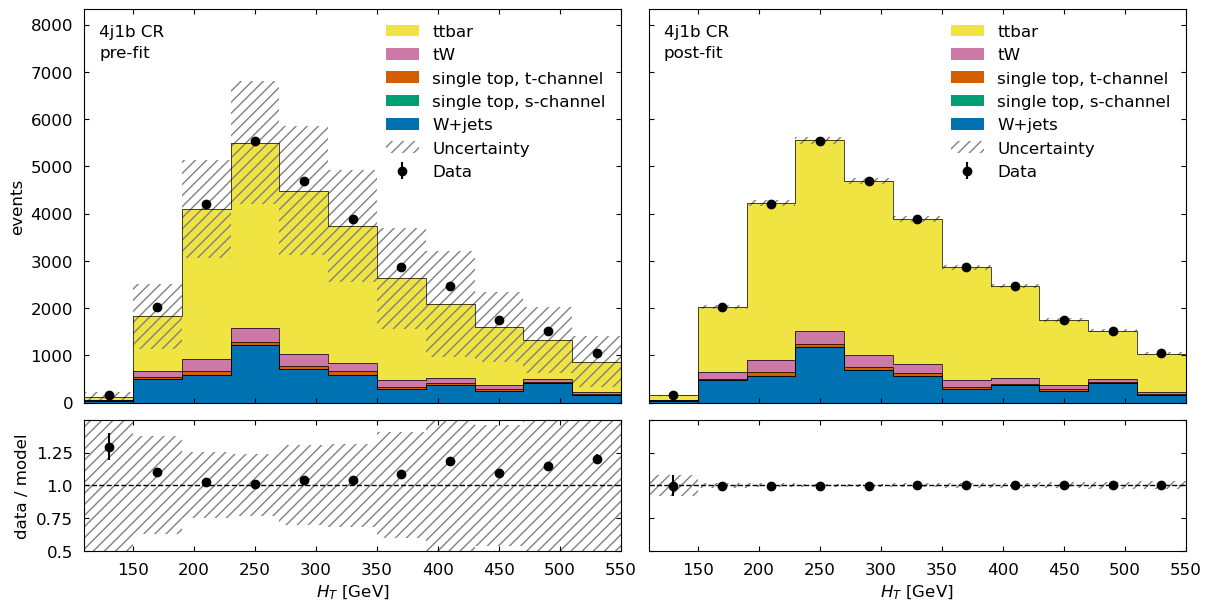

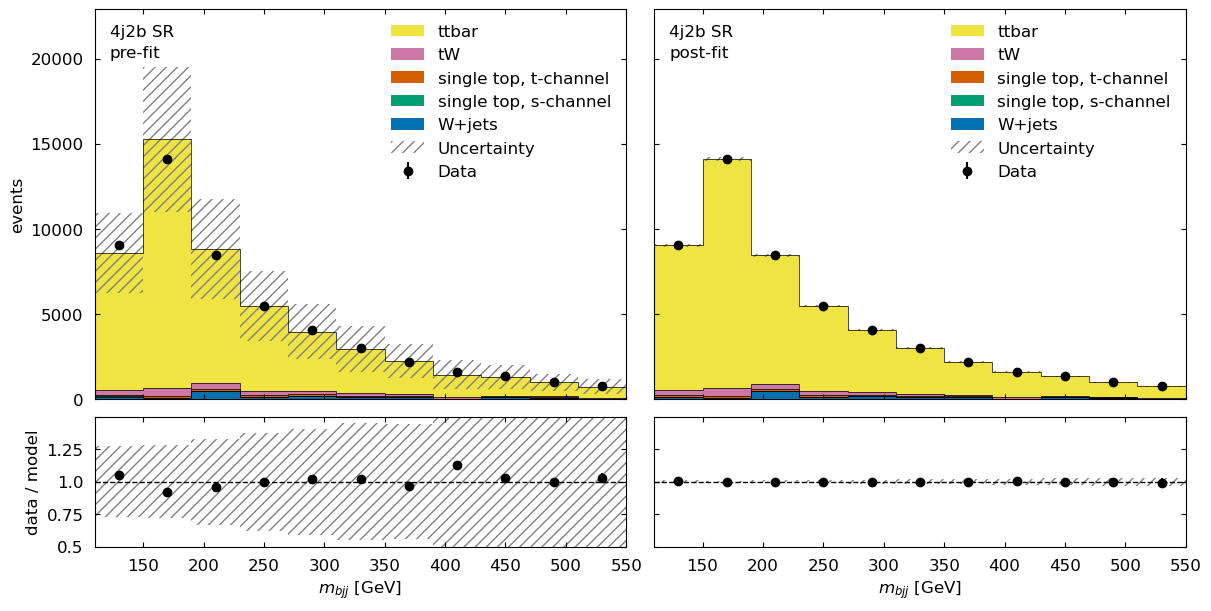

In [10]:
model_prediction = cabinetry.model_utils.prediction(model)
model_prediction_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
figs = cabinetry.visualize.data_mc(model_prediction, data, close_figure=True, config=cabinetry_config)
# below method reimplements this visualization in a grid view
utils.plotting.plot_data_mc(model_prediction, model_prediction_postfit, data, cabinetry_config)

In [28]:
#model_prediction.model_yields
#model.config.samples

['W+jets', 'single top, s-channel', 'single top, t-channel', 'tW', 'ttbar']

In [16]:
model.config.channels

['4j1b CR', '4j2b SR']

In [65]:
output = {}

for i_chan, channel in enumerate(model.config.channels):
    for j_sam, sample in enumerate(model.config.samples):
        yields = model_prediction.model_yields[i_chan][j_sam]
        uncertainties = model_prediction.total_stdev_model_bins[i_chan][j_sam]
        num_bins = len(yields)
        for k_bin in range(num_bins):
            key = f"{channel} {sample} bin{k_bin}"
            value = {"value": yields[k_bin], "symerror": uncertainties[k_bin]}
            output[key] = value
#output

In [63]:
independent_variables = []
dependent_variables = []
for key in output.keys():
    columns = key.split()
    independent_variables.append(f"{columns[0]} {columns[1]} {columns[-1]}")
    dependent_variables.append(' '.join(columns[2:-1]))

In [15]:
from hepdata_lib import Submission

submission = Submission()

Welcome to JupyROOT 6.30/02


In [14]:
#This is the required installations
#!pip install hepdata_lib
#!mamba install -c conda-forge root htcondor=10.8 --yes

In [69]:
from hepdata_lib import Table, Variable, Uncertainty
import hist.intervals

def create_hep_data_table(index, independent_variables, model, model_prediction):
    table = Table(f"4j{index}b Figure")

    var = Variable("sample", is_independent=True, is_binned=False, units="should be some units for the samples??")
    var.values = sorted(set(value for value in independent_variables if f'4j{index}b' in value), key=independent_variables.index)
    table.add_variable(var)

    for i, info in enumerate(model.config.samples):
        data_var = Variable(model.config.samples[i], is_independent=False, is_binned=False, units="Number of jets")
        data_var.values = model_prediction.model_yields[index-1][i]

        unc = Uncertainty("A symmetric error", is_symmetric=True)
        unc.values = model_prediction.total_stdev_model_bins[index-1][i]

        data_var.add_uncertainty(unc)
        table.add_variable(data_var)

    return table

In [70]:
tab1 = create_hep_data_table(1, independent_variables, model, model_prediction)
tab2 = create_hep_data_table(2, independent_variables, model, model_prediction)
submission.add_table(tab1)
submission.create_files("4j1b", remove_old=True)

	 error - submission.yaml is invalid HEPData YAML.
	 error - Duplicate table name: 4j1b Figure
	 error - Duplicate table data_file: 4j1b_figure.yaml


AssertionError: The tar ball is not valid

In [68]:
USE_INFERENCE = True

In [70]:
# load the ml workspace (uses the ml observable instead of previous method)
if USE_INFERENCE:
    config_ml = cabinetry.configuration.load("cabinetry_config_ml.yml")
    cabinetry.templates.collect(config_ml)
    cabinetry.templates.postprocess(config_ml)  # optional post-processing (e.g. smoothing)

    ws_ml = cabinetry.workspace.build(config_ml)
    ws_pruned = pyhf.Workspace(ws_ml).prune(channels=["Feature3", "Feature8", "Feature9",
                                                      "Feature10", "Feature11", "Feature12",
                                                      "Feature13", "Feature14", "Feature15",
                                                      "Feature16", "Feature17", "Feature18",
                                                      "Feature19"])

    cabinetry.workspace.save(ws_pruned, "workspace_ml.json")

In [71]:
if USE_INFERENCE:
    model_ml, data_ml = cabinetry.model_utils.model_and_data(ws_pruned)

In [72]:
# obtain model prediction before and after fit
if USE_INFERENCE:
    model_prediction = cabinetry.model_utils.prediction(model_ml)
    fit_results_mod = cabinetry.model_utils.match_fit_results(model_ml, fit_results)
    model_prediction_postfit = cabinetry.model_utils.prediction(model_ml, fit_results=fit_results_mod)

In [74]:
#filtered_values__ml = sorted(set(value for value in independent_variables_ml if 'Feature' in value), key=independent_variables_ml.index)

In [78]:
#model_prediction.total_stdev_model_bins

In [88]:
output_ml_postfit = {} #This is the dictionary with values for the ML figures

for i_chan, channel in enumerate(model_ml.config.channels):
    for j_sam, sample in enumerate(model_ml.config.samples):
        yields = model_prediction_postfit.model_yields[i_chan][j_sam]
        uncertainties = model_prediction_postfit.total_stdev_model_bins[i_chan][j_sam]
        num_bins = len(yields)
        for k_bin in range(num_bins):
            key = f"{channel} {sample} bin{k_bin}"
            value = {"value": yields[k_bin], "symerror": uncertainties[k_bin]}
            output_ml_postfit[key] = value
#output_ml_postfit

In [89]:
#Alright, let's create a dictionary with values for the 
independent_variables_ml = []
dependent_variables_ml = []
for key in output_ml_postfit.keys():
    columns = key.split()
    independent_variables_ml.append(f"{columns[0]} {columns[-1]}")
    dependent_variables_ml.append(' '.join(columns[1:-1]))

#independent_variables_ml

In [80]:
model_ml.config.channels

['Feature0',
 'Feature1',
 'Feature2',
 'Feature4',
 'Feature5',
 'Feature6',
 'Feature7']

In [113]:
result_list = []
for feature in model_ml.config.channels:
    for bin_num in range(num_bins):
        result_list.append(f'{feature} bin{bin_num}')
#result_list

In [117]:
filtered_set = [item for item in result_list if item.startswith('Feature0')]

In [118]:
filtered_set

['Feature0 bin0',
 'Feature0 bin1',
 'Feature0 bin2',
 'Feature0 bin3',
 'Feature0 bin4',
 'Feature0 bin5',
 'Feature0 bin6',
 'Feature0 bin7',
 'Feature0 bin8',
 'Feature0 bin9',
 'Feature0 bin10',
 'Feature0 bin11',
 'Feature0 bin12',
 'Feature0 bin13',
 'Feature0 bin14',
 'Feature0 bin15',
 'Feature0 bin16',
 'Feature0 bin17',
 'Feature0 bin18',
 'Feature0 bin19',
 'Feature0 bin20',
 'Feature0 bin21',
 'Feature0 bin22',
 'Feature0 bin23',
 'Feature0 bin24']

In [103]:
num_bins, len(yields)

(25, 25)

In [ ]:
for k_bin in len(yields):
    

In [81]:
model_ml.config.samples

['W+jets', 'single top, s-channel', 'single top, t-channel', 'tW', 'ttbar']

In [83]:
model_prediction.total_stdev_model_bins[0][1]

[0.022364651399830758,
 0.07768618013446411,
 0.7551098598106922,
 0.8880393723878882,
 0.7368015943268846,
 0.7726956705165942,
 0.6168552712417589,
 0.4380792312724379,
 0.2968596868572592,
 0.25110602517602604,
 0.15007619583475337,
 0.14888072929020413,
 0.11973169874161396,
 0.15751772447761336,
 0.08149579654558199,
 0.11343533545807892,
 0.14544815332740052,
 0.11994448567276292,
 0.14237037030309604,
 0.09333433944292664,
 0.14182114237085078,
 0.127546971535295,
 0.12107192597289138,
 0.12080105340628115,
 0.059874278036754776]

In [119]:
from hepdata_lib import Table, Variable, Uncertainty
import hist.intervals

tab1_ml = Table("Feature 0")
var = Variable("sample", is_independent=True, is_binned=False, units="should be some units for the samples??")
var.values = filtered_set = [item for item in result_list if item.startswith('Feature0')]
tab1_ml.add_variable(var)

index = -1
for info in model_ml.config.samples:
    index +=1 
    data_var = Variable(model_ml.config.samples[index], is_independent=False, is_binned=False, units="Number of jets")
    data_var.values = model_prediction.model_yields[0][index]
    
    unc = Uncertainty("A symmetric error", is_symmetric=True)
    unc.values = model_prediction.total_stdev_model_bins[0][index]
    
    data_var.add_uncertainty(unc)
    tab1_ml.add_variable(data_var)

In [120]:
submission.add_table(tab1_ml)
#submission.add_table(tab2)
submission.create_files("Feature0", remove_old=True)

	 error - submission.yaml is invalid HEPData YAML.
	 error - Duplicate table name: 4j1b Figure
	 error - Duplicate table data_file: 4j1b_figure.yaml


AssertionError: The tar ball is not valid